### Bayesian Optimization Loop

#### Why Use Bayesian Optimization?
Bayesian Optimization (BO) is particularly effective for expensive black-box functions, especially those with continuous numerical inputs and unconstrained optimization problems.

In this case, we want to implement our own BO algorithm using a Gaussian Process (GP) as a surrogate model and Expected Improvement (EI) as the acquisition function. Our goal is to minimize the following univariate function:

$$f: [0,1] \rightarrow \mathbb{R}, \quad x \mapsto 2x \cdot \sin(14x)$$

#### Methods of Sampling:
- Uniform random sampling of initial points
- [Latin Hypercube Sampling](https://en.wikipedia.org/wiki/Latin_hypercube_sampling)


In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

np.random.seed(32)

def f(x):
    return 2*x * np.sin(14*x) 

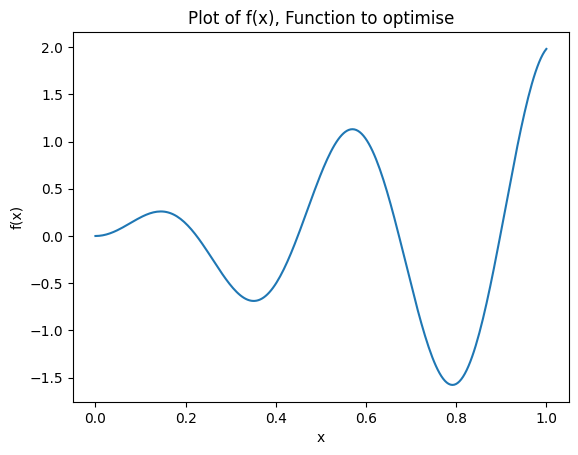

In [39]:
X = np.linspace(0,1, 250)
plt.plot(X, f(X))
plt.title("Plot of f(x), Function to optimise")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

#### Bayesian Optimization Loop Pseudo Code

Let $ D $ be the initial design consisting of $ \{(x^{[1]}, y^{[1]}), \dots, (x^{[n]}, y^{[n]})\} $.

For each iteration $ t $, with a maximum of $ T $ iterations:

1. Find $ x^* $ where the acquisition function is maximized:
   $$ x^* = \arg\max_{x \in \mathcal{X}} \alpha(x; \mathcal{GP}_t), $$
   where $ \alpha $ is the acquisition function and $ \mathcal{GP}_t $ is the Gaussian process model at iteration $ t $.

2. Evaluate the true objective function at $ x^* $:
   $$ y^* = f(x^*). $$

3. Augment the dataset $ D $ with the new observation:
   $$ D \leftarrow D \cup \{(x^*, y^*)\}. $$

4. Update the Gaussian process model $ \mathcal{GP}_t $ with the new dataset $ D $.

Return the optimal solution $ x_{\text{opt}} $:
$$ x_{\text{opt}} = \arg\max_{x \in D} f(x). $$


#### RBF Kernel

The Radial Basis Function (RBF) kernel is given by:

$$
k(x_1, x_2) = \sigma_f^2 \exp\left(-\frac{\|x_1 - x_2\|^2}{2 \cdot \text{length\_scale}^2}\right)
$$

Where:
- $\sigma_f^2$: Signal variance (controls the scale of the kernel).
- $\text{length\_scale}$: Length scale parameter (controls the smoothness).

The Kernel/Gram matrix is defined as:

$$
\mathbf{K} = \begin{bmatrix}
k(x_1, x_1) & \cdots & k(x_1, x_n) \\
\vdots & \ddots & \vdots \\
k(x_n, x_1) & \cdots & k(x_n, x_n)
\end{bmatrix}
$$

For a test input $\bold{x}$, the kernel vector for $\bold{x}$ is:

$$
k(x) := \left( k(x, x^{[1]}), \dots, k(x, x^{[t]}) \right)^\top
$$

And the test evaluations for $\bold{x}$ are denoted as:

$$
\bold{y} := \left( y^{[1]}, \dots, y^{[t]} \right)^\top
$$


In [40]:
# Building a RBF_kernel
# https://en.wikipedia.org/wiki/Radial_basis_function_kernel
def k(x_1, x_2, sigma = 1, length_scale = 1):
    return sigma ** 2 * np.exp(-(np.square(x_1 - x_2))/ (2 * np.square(length_scale)))

def K(x, sigma = 1, length_scale = 1):
    n_samples = x.shape[0]
    K = np.zeros((n_samples, n_samples))
    
    # Compute pairwise RBF kernel values and populate the kernel matrix
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = k(x[i], x[j], sigma, length_scale)
    
    return K

# X = data
# x = test point
def k_test(x, X, sigma = 1, length_scale = 1):
    output = []
    for x_data in X:
        output.append(k(x, x_data, sigma, length_scale))
    output = np.array(output)
    return output.reshape(-1,1)

#### Posterior Predictive Distribution

The posterior predictive distribution for a test point $\bold{x} \in S$ under zero mean is:

$$
Y(x) \mid x, D[t] \sim \mathcal{N} \left( \hat{f}(x), \hat{s}^2(x) \right)
$$

Where:
- The predicted mean is given by:

$$
\hat{f}(\bold{x}) = k(\bold{x})^\top \bold{K}^{-1} \bold{y}
$$

- The predicted variance is:

$$
\hat{s}^2(\mathbf{x}) = k(\mathbf{x}, \mathbf{x}) - \mathbf{k}(\mathbf{x})^\top \mathbf{K}^{-1} \mathbf{k}(\mathbf{x})
$$


In [41]:
def predict_f_mean(x, X, y, sigma = 1, length_scale = 1):
    K_matix = K(X, sigma, length_scale)
    k_x = k_test(x, X, sigma, length_scale)
    K_inv = np.linalg.inv(K_matix)
    f_x = np.dot(k_x.T, np.dot(K_inv, y))
    return f_x


def predict_f_sd(x, X, sigma = 1, length_scale = 1):
    self_x = k(x, x)

    K_matix = K(X, sigma, length_scale)
    k_x = k_test(x, X, sigma, length_scale)
    K_inv = np.linalg.inv(K_matix)
    f_x = self_x - np.dot(k_x.T, np.dot(K_inv, k_x).reshape(-1))
    print(np.dot(k_x.T, np.dot(K_inv, k_x)).reshape(-1))
    return f_x

# This is just combining both of the mean and standard deviation for speed reasons
# also to calcuate multiple x -> x must be a vector here
def predict_f(x, X, y, sigma = 1, length_scale = 1):
    K_matix = K(X, sigma, length_scale)
    K_inv = np.linalg.inv(K_matix)

    #ordered by same x
    output_mean = []
    output_sd = []

    for x_point in x:
        k_x_self_x = k(x_point, x_point, sigma, length_scale)
        k_x = k_test(x_point, X, sigma, length_scale)
        output_mean.append(np.dot(k_x.T, np.dot(K_inv, y)))

        # Using max to try and fix some numerical stability issues 
        sd2 = np.maximum(k_x_self_x - np.dot(k_x.T, np.dot(K_inv, k_x)),0).reshape(-1)
        output_sd.append(sd2)

    output_mean = np.array(output_mean)
    output_sd = np.array(output_sd)

    return (output_mean, output_sd)      

In [42]:
X = np.linspace(0,1,250)

# We will sample our point uniformly at random in the domain of f (4 of them)
initial_x = np.random.uniform(0,1,1)
initial_y = f(initial_x)

sigma = 1
length_scale = 0.2

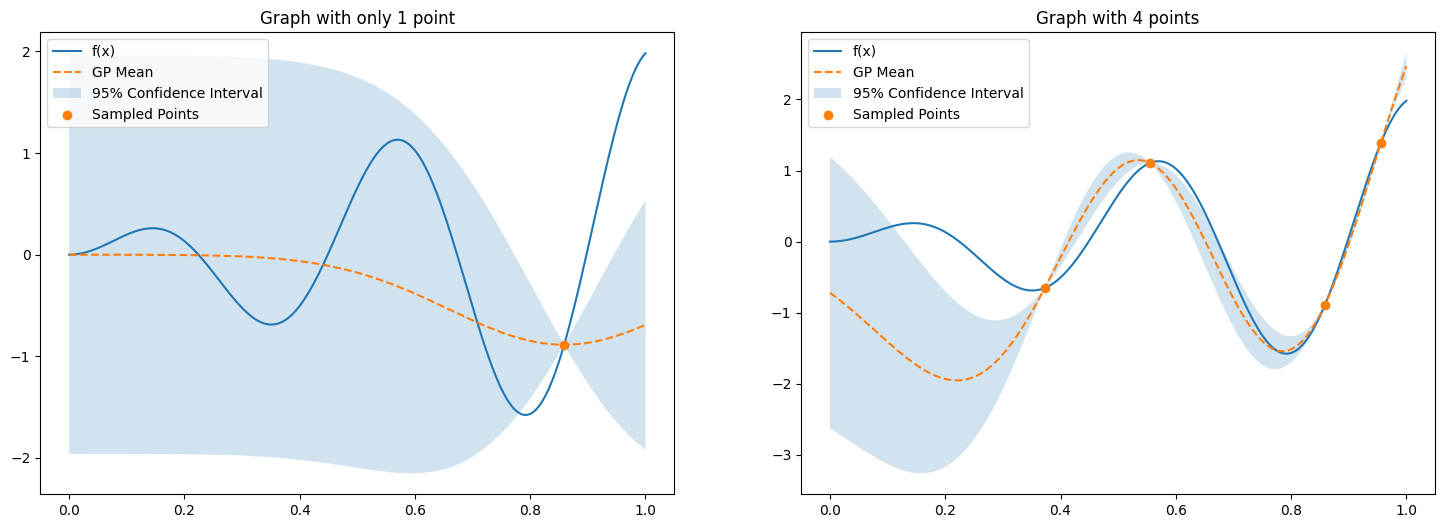

In [43]:
mean_single, sd2 = predict_f(X, initial_x, initial_y, sigma, length_scale)
sd2 = np.nan_to_num(sd2, nan=0, posinf=0, neginf=0)
sd_single = np.sqrt(sd2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
ax1.plot(X, f(X), label="f(x)")
ax1.plot(X, mean_single, '--', label="GP Mean")
ax1.fill_between(
    X.ravel(),
    (mean_single - 1.96 * sd_single).ravel(),
    (mean_single + 1.96 * sd_single).ravel(),
    alpha = 0.2,
    label="95% Confidence Interval"
)
ax1.scatter(initial_x, initial_y, zorder=10, label="Sampled Points")
ax1.legend()

ax1.set_title("Graph with only 1 point")
ax2.set_title("Graph with 4 points")

extra_x = np.random.uniform(0, 1, 3)
single_x, single_y = initial_x.copy(), initial_y.copy()
initial_x = np.concatenate([initial_x, extra_x], axis=0)
initial_y = np.concatenate([initial_y, f(extra_x)], axis=0)

mean, sd2 = predict_f(X, initial_x, initial_y, sigma, length_scale)
sd2 = np.nan_to_num(sd2, nan=0, posinf=0, neginf=0)
sd = np.sqrt(sd2)
ax2.plot(X, f(X), label="f(x)")
ax2.plot(X, mean, '--', label="GP Mean")
ax2.fill_between(
    X.ravel(),
    (mean - 1.96 * sd).ravel(),
    (mean + 1.96 * sd).ravel(),
    alpha = 0.2,
    label="95% Confidence Interval"
)
ax2.scatter(initial_x, initial_y, zorder=10, label="Sampled Points")
ax2.legend()
# ax2.plot(X, mean - T * sd)

plt.show()

We want to:

- Find a trade-off between exploration (areas we have not visited yet) and exploitation (searching around good design points).
- To sequentially propose new points based on the surrogate model (SM), we use acquisition functions.

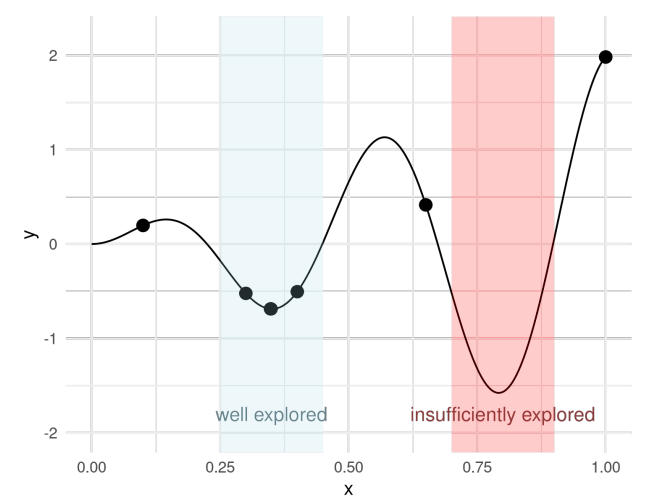

Let:
$$ f_{\text{min}} := \min \left( f(x^{[1]}), \ldots, f(x^{[t]}) \right) $$ 
denote the best observed value so far.

We aim to find $x^{[t+1]}$ that minimizes the Lower Confidence Bound (LCB):
$$
\text{a}_{\text{LCB}}(x) = \hat{f}(x) - \tau \hat{s}(x)
$$
where $ \tau > 0 $ is a constant that controls the trade-off between "mean" and "uncertainty."

The LCB is conceptually simple and does not rely on distributional assumptions of the posterior predictive distribution under the surrogate model (SM).


In [44]:
def a_lcb(mean, sd, T):
    return mean - T * sd

[]

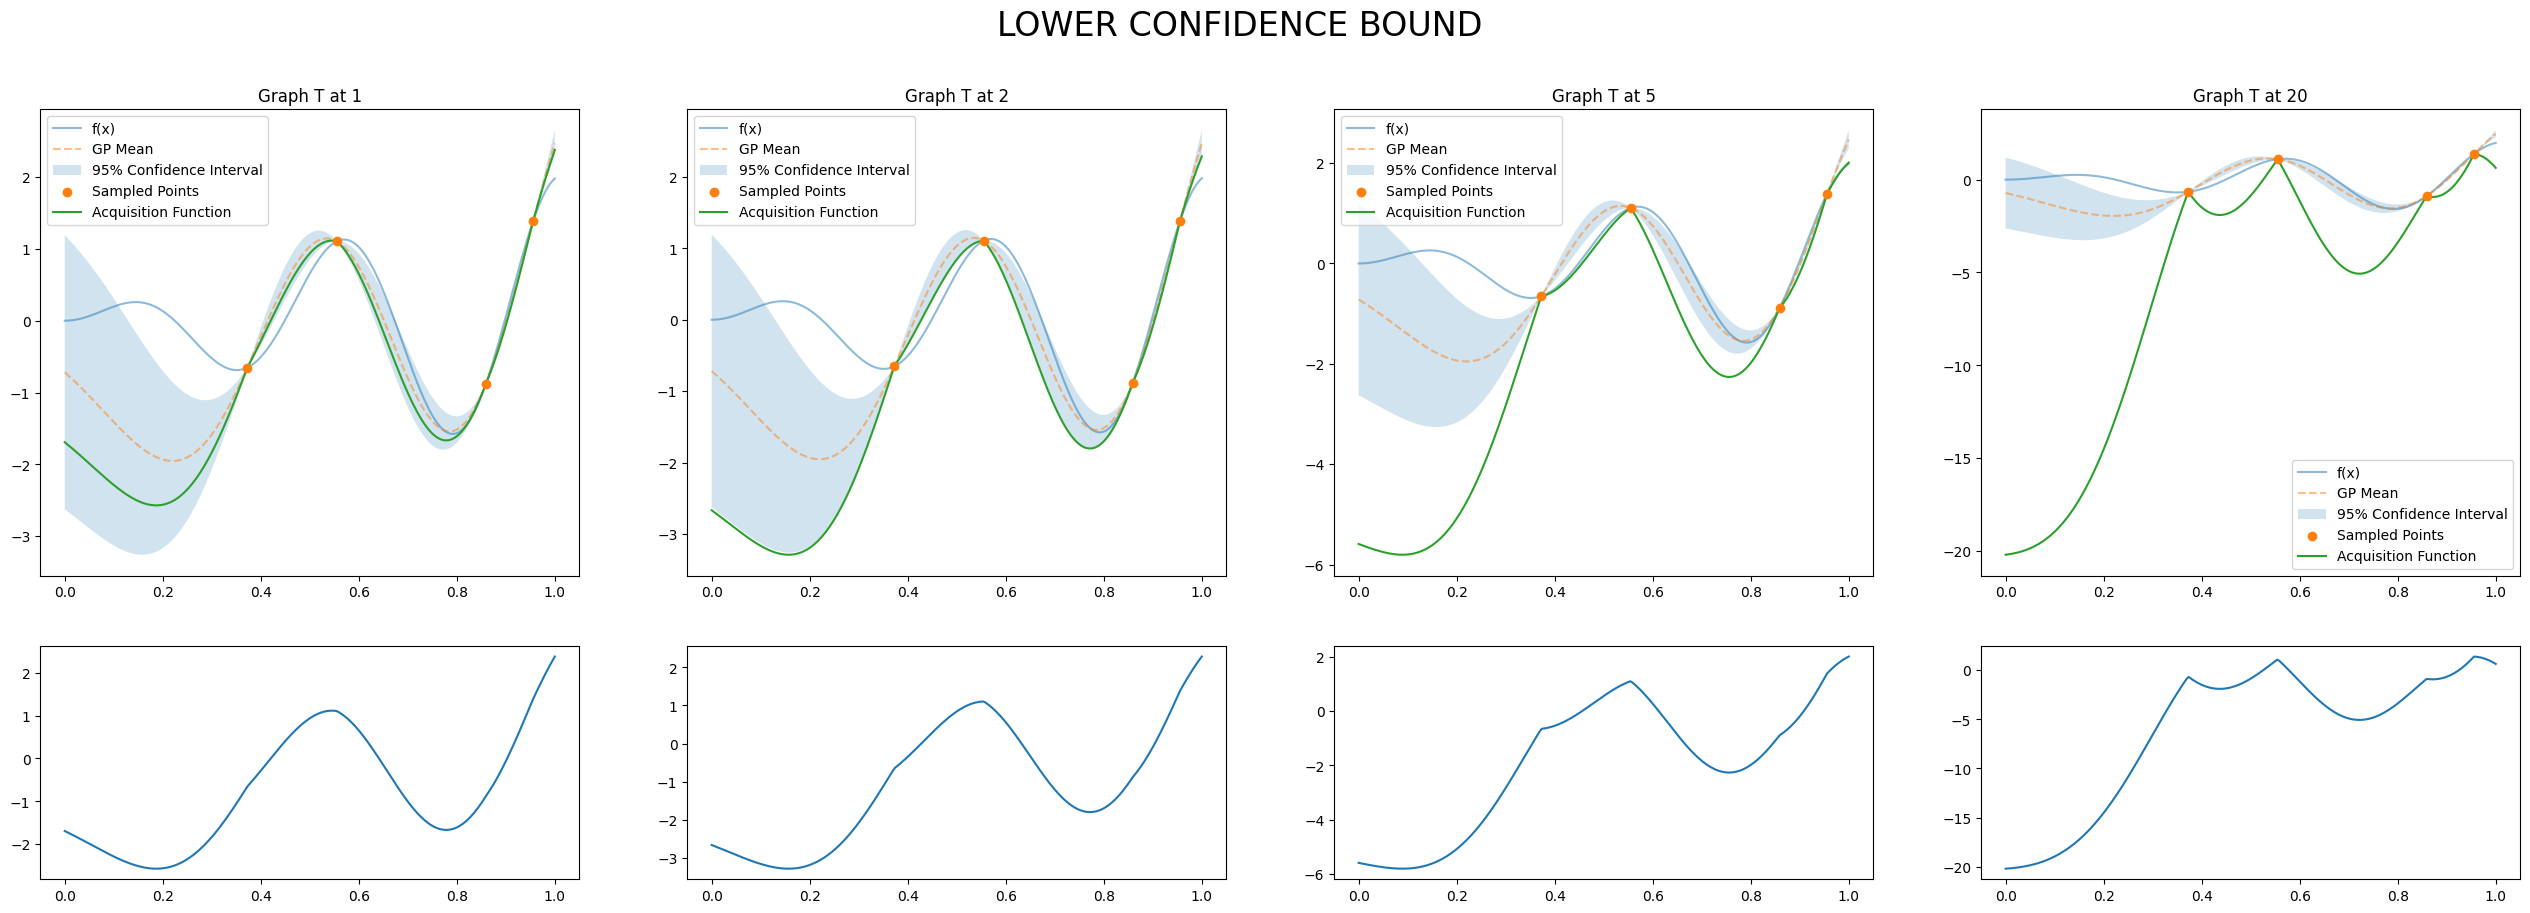

In [45]:
Ts = [1,2,5,20]

fig, axs = plt.subplots(2, len(Ts), figsize=(8*len(Ts), 10), gridspec_kw={'height_ratios': [2, 1]})
plt.suptitle("LOWER CONFIDENCE BOUND", fontsize=24)

mean, sd2 = predict_f(X, initial_x, initial_y, sigma, length_scale)
sd2 = np.nan_to_num(sd2, nan=0, posinf=0, neginf=0)
sd = np.sqrt(sd2)

for i, T in enumerate(Ts):
    axs[0,i].set_title(f"Graph T at {T}")
    axs[0,i].plot(X, f(X), label="f(x)", alpha = 0.5)
    axs[0,i].plot(X, mean, '--', label="GP Mean", alpha = 0.5)

    axs[0,i].fill_between(
        X.ravel(),
        (mean - 1.96 * sd).ravel(),
        (mean + 1.96 * sd).ravel(),
        alpha = 0.2,
        label="95% Confidence Interval"
    )

    axs[0,i].scatter(initial_x, initial_y, zorder=10, label="Sampled Points")
    axs[0,i].plot(X, a_lcb(mean, sd, T), label="Acquisition Function")
    axs[0,i].legend()
    axs[1,i].plot(X, a_lcb(mean, sd, T), label="Acquisition Function")



plt.plot()

#### Probability of Improvement (PI)
Suppose that we’d like to maximize $f(x)$, and the best solution we have so far is $x^⋆$. Then, we can define “improvement”, $I(x)$, as:
$$I(x)=max(f(x)−f(x^⋆),0)$$
At point $x$ the value of the function $f(x)$ is sampled from a normal distribution with mean $\mu$ and variance $\sigma ^2 (x)$
$$f(x) \sim \mathcal{N} (\mu, \sigma ^2)$$
So rewriting we get:
$$I(x)=max(f(x)−f(x^⋆),0)  = max(\mu (x)+\sigma (x)z−f(x^⋆),0) \text {, where }z\sim \mathcal{N}(0,1)$$
and for minimisation:
$$I(x)=max(f(x^*)−f(x),0)  = max(f(x^*) - (\mu (x)+\sigma (x)z),0) \text {, where }z\sim \mathcal{N}(0,1)$$

In [46]:
from scipy.stats import norm

def probability_of_improvement(pred_mean, pred_std, y_best, xi=0.01):
    pred_std = np.maximum(pred_std, 1e-9)  # Prevent division by zero
    improvement_threshold = y_best - xi  # For minimization, we want improvement below this threshold

    Z = (improvement_threshold - pred_mean) / pred_std
    pi = norm.cdf(Z)  # The probability of having a value lower than the improvement threshold
    
    return pi

Probability of Improvement (PI) considers only the probability of improving our current best estimate, but it does not factor in the magnitude of the improvement. Therefore, we use Expected Improvement (EI) instead.

The Expected Improvement is given by:

$$
EI(x) \equiv E[I(x)] = \int_{-\infty}^{\infty} I(x) \varphi(z) \, dz
$$

For more detailed math and derivation, see: [Expected Improvement (EI)](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html#:~:text=.-,Expected%20Improvement%20(EI),-PI%20considers%20only).

The formula for Expected Improvement is:

$$
EI(x; \xi) = (\mu - f(x^\star) - \xi) \Phi\left(\frac{\mu - f(x^\star) - \xi}{\sigma}\right) + \sigma \varphi\left(\frac{\mu - f(x^\star) - \xi}{\sigma}\right)
$$

For minimization, the Expected Improvement is:

$$
EI(x; \xi) = (f(x^\star) - \xi - \mu) \Phi\left(\frac{f(x^\star) - \xi - \mu}{\sigma}\right) + \sigma \varphi\left(\frac{f(x^\star) - \xi - \mu}{\sigma}\right)
$$


In [47]:
def expected_improvement(pred_mean, pred_std, y_best, xi=0.01):
    pred_std = np.maximum(pred_std, 1e-9)  # Prevent division by zero

    improvement = y_best - xi - pred_mean 
    
    # Compute expected improvement for minimization
    ei = (improvement * norm.cdf(improvement / pred_std) + 
          pred_std * norm.pdf(improvement / pred_std))
    
    return ei

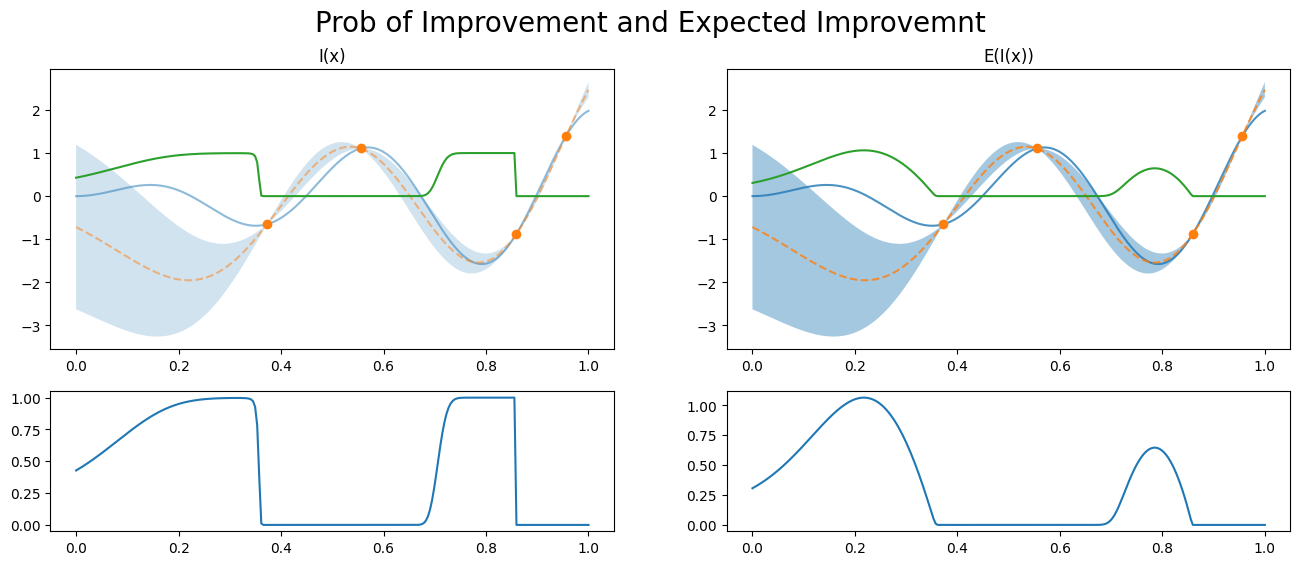

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(16, 6), gridspec_kw={'height_ratios': [2, 1]})
plt.suptitle("Prob of Improvement and Expected Improvemnt", fontsize=20)

axs[0,0].set_title(f"I(x)")

axs[0,0].plot(X, f(X), label="f(x)", alpha = 0.5)
axs[0,0].plot(X, mean, '--', label="GP Mean", alpha = 0.5)

axs[0,0].fill_between(
    X.ravel(),
    (mean - 1.96 * sd).ravel(),
    (mean + 1.96 * sd).ravel(),
    alpha = 0.2,
    label="95% Confidence Interval"
)

axs[0,0].scatter(initial_x, initial_y, zorder=10, label="Sampled Points")

best_y = np.min(initial_y)
axs[0,0].plot(X, probability_of_improvement(mean, sd, best_y))

####
axs[0,1].set_title(f"E(I(x))")

axs[0,1].plot(X, f(X), label="f(x)", alpha = 0.8)
axs[0,1].plot(X, mean, '--', label="GP Mean", alpha = 0.8)

axs[0,1].fill_between(
    X.ravel(),
    (mean - 1.96 * sd).ravel(),
    (mean + 1.96 * sd).ravel(),
    alpha = 0.4,
    label="95% Confidence Interval"
)

axs[0,1].plot(X, expected_improvement(mean, sd, best_y))
axs[0,1].scatter(initial_x, initial_y, zorder=10, label="Sampled Points")


axs[1,0].plot(X, probability_of_improvement(mean, sd, best_y))
axs[1,1].plot(X, expected_improvement(mean, sd, best_y))
plt.show()


We will perform a simple search to find the optimum of the Lower Confidence Bound (LCB). This can be done using methods like grid search or random search. However, it’s important to note that any optimization technique can be applied here.


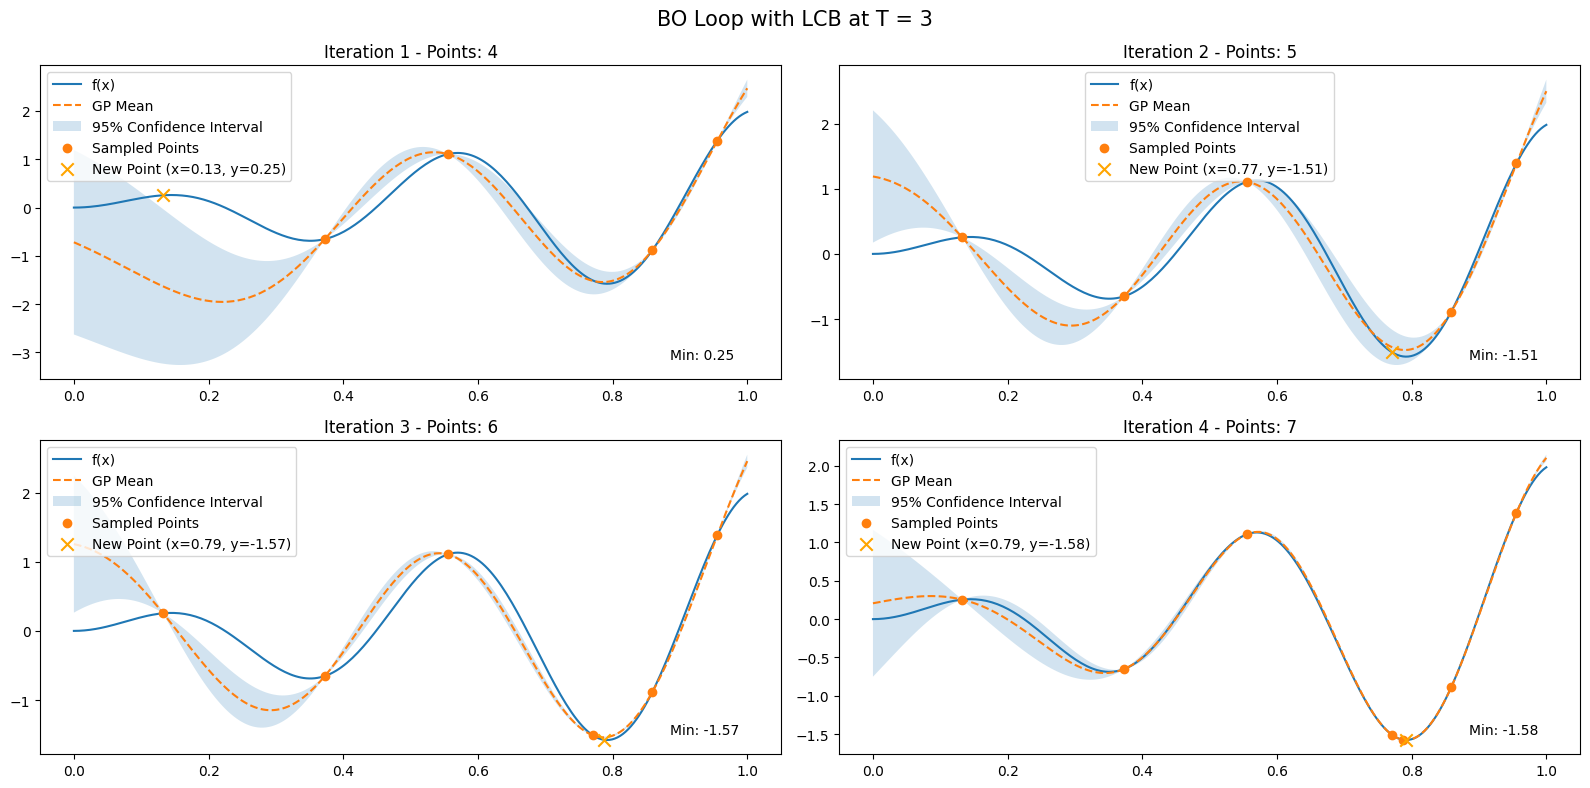

In [49]:
T = 3

x_points = initial_x.copy()
y_points = initial_y.copy()

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing
plt.suptitle("BO Loop with LCB at T = 3", fontsize=15)

for i in range(4):
    mean, sd2 = predict_f(X, x_points, y_points, sigma, length_scale)
    sd2 = np.nan_to_num(sd2, nan=0, posinf=0, neginf=0)
    sd = np.sqrt(sd2)

    ax = axes[i]

    ax.plot(X, f(X), label="f(x)")
    ax.plot(X, mean, '--', label="GP Mean")
    ax.fill_between(
        X.ravel(),
        (mean - 1.96 * sd).ravel(),
        (mean + 1.96 * sd).ravel(),
        alpha=0.2,
        label="95% Confidence Interval"
    )
    ax.scatter(x_points, y_points, zorder=10, label="Sampled Points") #, color='blue'
    
    
    new_min = X[np.argmin(a_lcb(mean, sd, T))]
    ax.scatter(new_min, f(new_min), color='orange', zorder=15, marker="x", s = 80, label=f"New Point (x={new_min:.2f}, y={f(new_min):.2f})")

    # Add the minimum value annotation
    ax.text(0.85, 0.1, f'Min: {f(new_min):.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

    # Title with iteration number and number of points
    ax.set_title(f"Iteration {i + 1} - Points: {len(x_points)}")
    
    ax.legend()

    x_points = np.concatenate([x_points, [new_min]], axis=0)
    y_points = np.concatenate([y_points, [f(new_min)]], axis=0)

plt.tight_layout()
plt.show()


### Running the BO Loop using the Expected Improvement Acquisition Function

In this approach, we use the Expected Improvement (EI) acquisition function to guide the search for the optimal solution. At each iteration, the next point is selected by maximizing the EI function, which balances exploration and exploitation based on the surrogate model. The surrogate model is updated with each new evaluation, and the process continues until convergence or a set number of iterations.


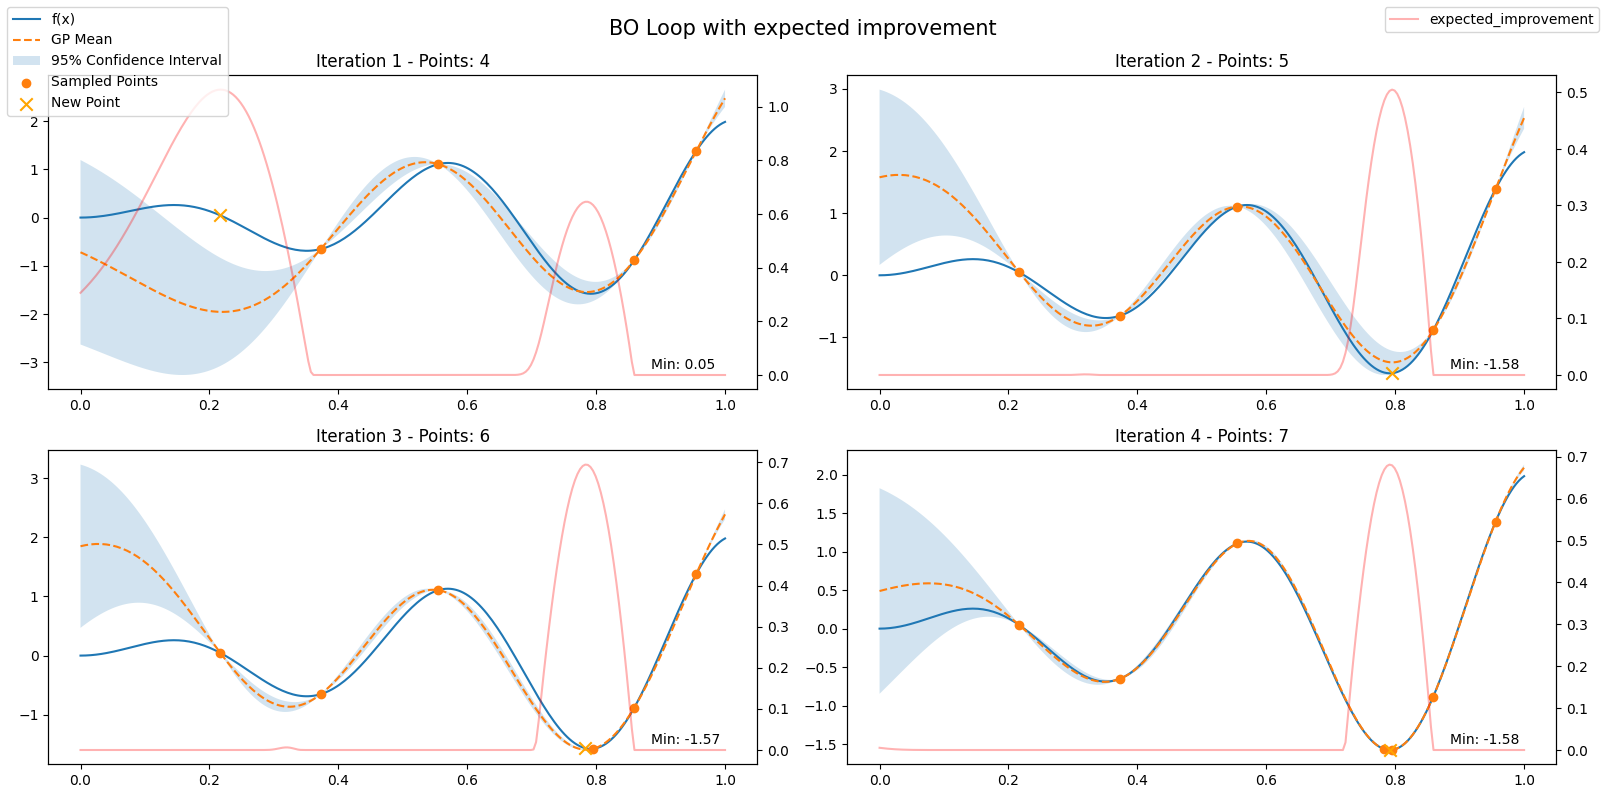

In [50]:
x_points = initial_x.copy()
y_points = initial_y.copy()
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
plt.suptitle("BO Loop with expected improvement", fontsize=15)

axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing
for i in range(4):
    mean, sd2 = predict_f(X, x_points, y_points, sigma, length_scale)
    sd2 = np.nan_to_num(sd2, nan=0, posinf=0, neginf=0)
    sd = np.sqrt(sd2)

    ax = axes[i]
    ax2 = ax.twinx()
    best_y = np.min(initial_y)

    ax2.plot(X,expected_improvement(mean, sd, best_y), label="expected_improvement", color = "red", alpha=0.3)

    ax.plot(X, f(X), label="f(x)")
    ax.plot(X, mean, '--', label="GP Mean")
    ax.fill_between(
        X.ravel(),
        (mean - 1.96 * sd).ravel(),
        (mean + 1.96 * sd).ravel(),
        alpha=0.2,
        label="95% Confidence Interval"
    )
    ax.scatter(x_points, y_points, zorder=10, label="Sampled Points") #, color='blue'
    
    
    new_min = X[np.argmax(expected_improvement(mean, sd, best_y))]

    ax.scatter(new_min, f(new_min), color='orange', zorder=15, marker="x", s = 80, label=f"New Point")

    # Add the minimum value annotation
    ax.text(0.85, 0.1, f'Min: {f(new_min):.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

    # Title with iteration number and number of points
    ax.set_title(f"Iteration {i + 1} - Points: {len(x_points)}")
    
    # ax.legend()
    

    x_points = np.concatenate([x_points, [new_min]], axis=0)
    y_points = np.concatenate([y_points, [f(new_min)]], axis=0)

fig.legend(handles=ax2.get_legend_handles_labels()[0], 
           labels=ax2.get_legend_handles_labels()[1])
fig.legend(handles=ax.get_legend_handles_labels()[0], 
           labels=ax.get_legend_handles_labels()[1], loc=2)

plt.tight_layout()
plt.show()


### Running the BO Loop with Noisy Objective Function

When the objective function $f(x)$ is noisy, we model the noisy observations using a Gaussian Process (GP) with added noise. The posterior predictive distribution for a test point $x$ given the data $D[t]$ is:

$$
f(x) \mid x, D[t] \sim \mathcal{N} \left( \hat{f}(x), \hat{s}^2(x) \right)
$$

Where the predicted mean and variance are given by:

$$
\hat{f}(x) = k(x)^\top (K + \sigma_\epsilon^2 I_t)^{-1} y
$$
$$
\hat{s}^2(x) = k(x, x) - k(x)^\top (K + \sigma_\epsilon^2 I_t)^{-1} k(x)
$$

Here:
- $K$ is the covariance matrix of the training points.
- $\sigma_\epsilon^2$ represents the noise variance.
- $I_t$ is the identity matrix of size $t$ (the number of training points).
- $k(x)$ is the vector of covariances between the test point $x$ and the training points.

This model accounts for both the underlying function and the noise in the observations, which helps guide the acquisition function (like EI) for noisy evaluations.


Normally, when the objective function is assumed to be noise-free, the variance at each training point $x^{[i]}$ is zero, i.e., $s^2(x^{[i]}) = 0$. This is because the surrogate model's prediction at training points is exact, with no uncertainty or noise in the observations. Now it is not.